In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

# NCLT keypoints matching

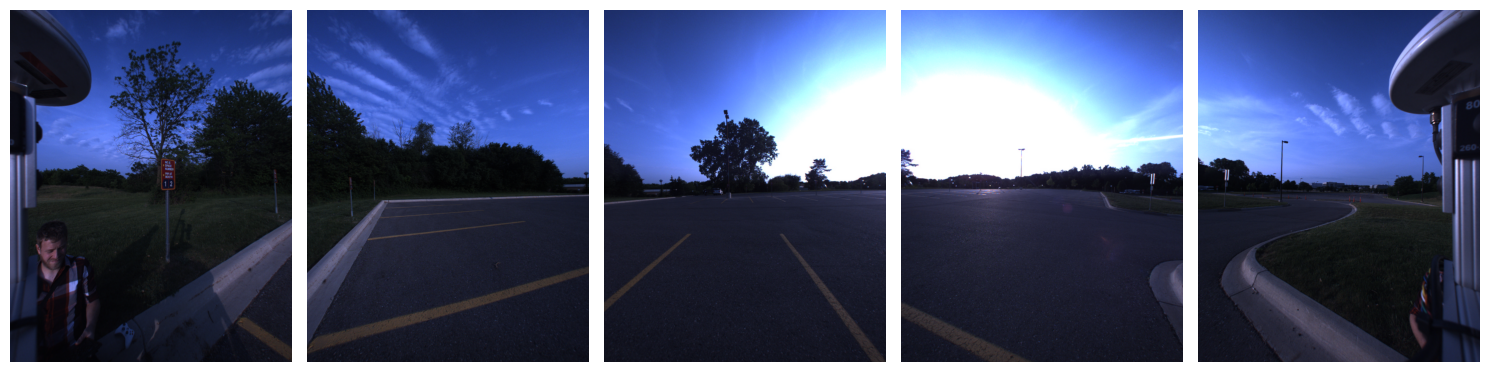

In [2]:
IMAGE_PATHS = []
for i in range(1, 6):
    IMAGE_PATHS.append(Path(f"./data/nclt_cam_{i}.png"))

nclt_images = [cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB) for p in IMAGE_PATHS]



fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for ax, img in zip(axes, nclt_images):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
def match_keypoints(images: list[np.ndarray]):
    # Инициализируем SIFT
    sift = cv2.SIFT_create()
    
    # Для хранения ключевых точек и дескрипторов
    keypoints_list = []
    descriptors_list = []
    
    # Находим ключевые точки и дескрипторы для каждого изображения
    for img in images:
        # Преобразуем в grayscale для более стабильных ключевых точек
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if len(img.shape) == 3 else img
        kp, des = sift.detectAndCompute(gray, None)
        keypoints_list.append(kp)
        descriptors_list.append(des)
    
    # Пары изображений, для которых будем находить сопоставления
    pairs = [(0, 1), (1, 2), (2, 3), (3, 4)]
    
    # Инициализируем BFMatcher с нормой L2
    bf = cv2.BFMatcher(cv2.NORM_L2)
    
    # Находим хорошие сопоставления между парами изображений
    good_matches_list = []
    
    # Используем разные цвета для линий между разными парами изображений
    colors = [(0, 255, 0), (255, 0, 255), (0, 165, 255), (255, 0, 0)]
    
    for (i1, i2) in pairs:
        matches_knn = bf.knnMatch(descriptors_list[i1], descriptors_list[i2], k=2)
        ratio_thresh = 0.6  # Снижаем порог для более строгой фильтрации
        good_matches = []
        for m_n in matches_knn:
            if len(m_n) < 2:  # Ensure two matches are available
                continue
            m, n = m_n
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
        # Если достаточно совпадений, используем RANSAC для фильтрации выбросов
        if len(good_matches) > 10:
            src_pts = np.float32([keypoints_list[i1][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints_list[i2][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            
            # Используем RANSAC для нахождения гомографии между изображениями
            H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
            # Фильтруем совпадения с помощью маски RANSAC
            ransac_matches = [good_matches[i] for i, inlier in enumerate(mask) if inlier[0]]
            good_matches = ransac_matches if ransac_matches else good_matches[:10]  # Защита от пустого списка
        
        good_matches_list.append(good_matches)
    
    # Создаем общую горизонтальную визуализацию
    # Находим максимальную высоту изображений
    max_height = max(img.shape[0] for img in images)
    
    # Добавляем промежуток между изображениями
    spacing = 20
    
    # Вычисляем общую ширину для нового изображения с учетом промежутков
    total_width = sum(img.shape[1] for img in images) + spacing * (len(images) - 1)
    
    # Создаем пустое изображение с белым фоном
    result_image = np.ones((max_height, total_width, 3), dtype=np.uint8) * 255
    
    # Отслеживаем текущую позицию для размещения изображения
    current_x = 0
    
    # Сохраняем начальные позиции x для каждого изображения
    image_positions = []
    
    # Размещаем изображения с промежутками
    for img in images:
        h, w = img.shape[:2]
        # Центрируем изображение по вертикали, если оно меньше максимальной высоты
        y_offset = (max_height - h) // 2
        
        # Копируем изображение в результирующее
        result_image[y_offset:y_offset+h, current_x:current_x+w] = img
        
        # Сохраняем позицию
        image_positions.append(current_x)
        
        # Перемещаемся к следующей позиции, добавляя промежуток
        current_x += w + spacing
    
    # Рисуем сопоставления на общем изображении
    for idx, ((i1, i2), good_matches) in enumerate(zip(pairs, good_matches_list)):
        # Ограничиваем количество отображаемых совпадений для читаемости
        max_matches_to_show = 50
        if len(good_matches) > max_matches_to_show:
            # Сортируем совпадения по расстоянию (лучшие вначале)
            good_matches = sorted(good_matches, key=lambda x: x.distance)[:max_matches_to_show]
        
        # Используем текущий цвет для данной пары изображений
        color = colors[idx]
        
        # Для каждого совпадения рисуем линию между соответствующими точками
        for match in good_matches:
            # Получаем позиции ключевых точек на обоих изображениях
            kp1 = keypoints_list[i1][match.queryIdx]
            kp2 = keypoints_list[i2][match.trainIdx]
            
            # Преобразуем координаты к общему изображению
            x1, y1 = int(kp1.pt[0]) + image_positions[i1], int(kp1.pt[1])
            x2, y2 = int(kp2.pt[0]) + image_positions[i2], int(kp2.pt[1])
            
            # Рисуем линию, соединяющую точки, с увеличенной толщиной (2 вместо 1)
            cv2.line(result_image, (x1, y1), (x2, y2), color, 2)
            # Рисуем небольшие круги вокруг ключевых точек для лучшей видимости
            cv2.circle(result_image, (x1, y1), 4, color, 2)
            cv2.circle(result_image, (x2, y2), 4, color, 2)
    
    # Add new code to draw keypoints with no connections
    connected_indices = {i: set() for i in range(len(images))}
    for (i1, i2), matches in zip(pairs, good_matches_list):
        for match in matches:
            connected_indices[i1].add(match.queryIdx)
            connected_indices[i2].add(match.trainIdx)
    for i, kp_list in enumerate(keypoints_list):
        for j, kp in enumerate(kp_list):
            if j not in connected_indices[i]:
                x, y = int(kp.pt[0]) + image_positions[i], int(kp.pt[1])
                cv2.circle(result_image, (x, y), 3, (0, 0, 255), -1)
    
    # Возвращаем результат и данные для склейки
    return result_image, keypoints_list, good_matches_list, pairs

In [4]:
def show_matched_keypoints(images):
    """
    Отображает изображения с сопоставленными ключевыми точками
    """
    result_image, _, _, _ = match_keypoints(images)
    
    # Отображаем результат
    plt.figure(figsize=(20, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

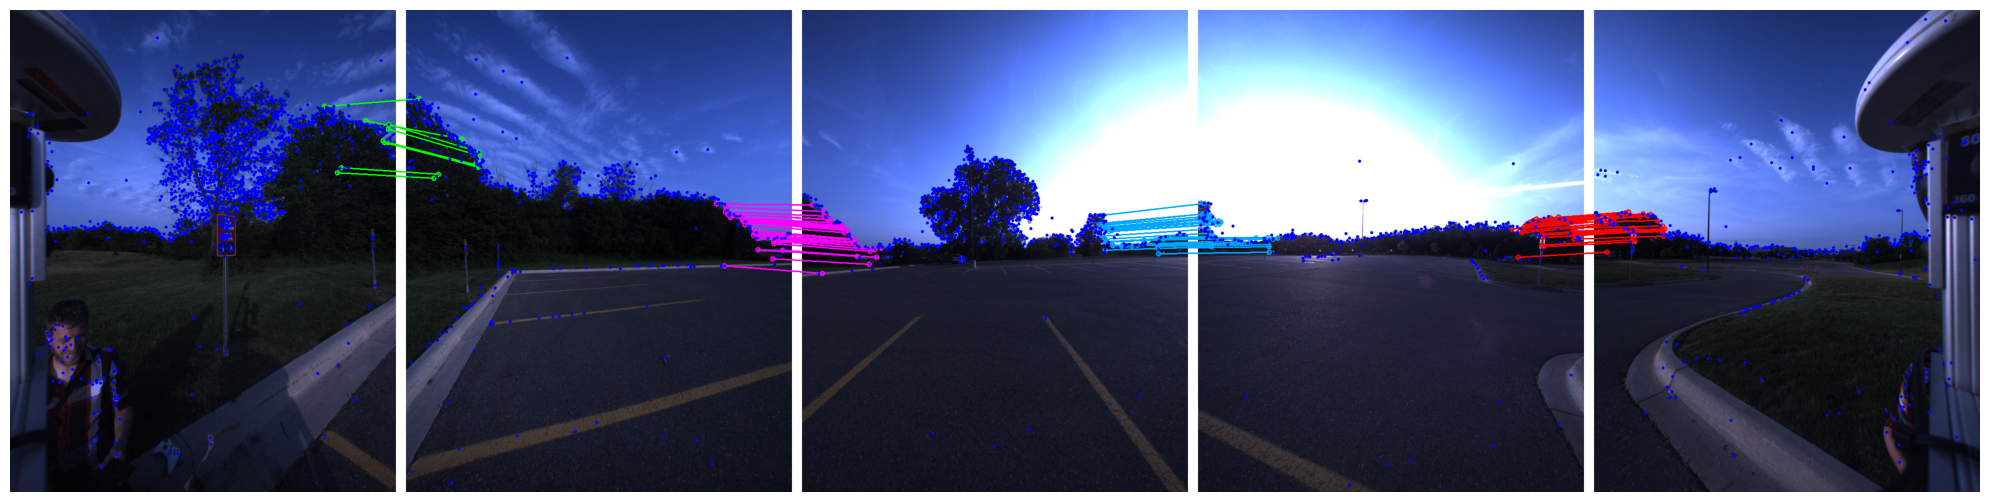

In [5]:
show_matched_keypoints(nclt_images)

# Harris detector

In [6]:
# image By Davidwkennedy - http://en.wikipedia.org/wiki/File:Bikesgray.jpg, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=8904801

bike_img = cv2.imread("data/Bikesgray.jpg", cv2.IMREAD_GRAYSCALE)

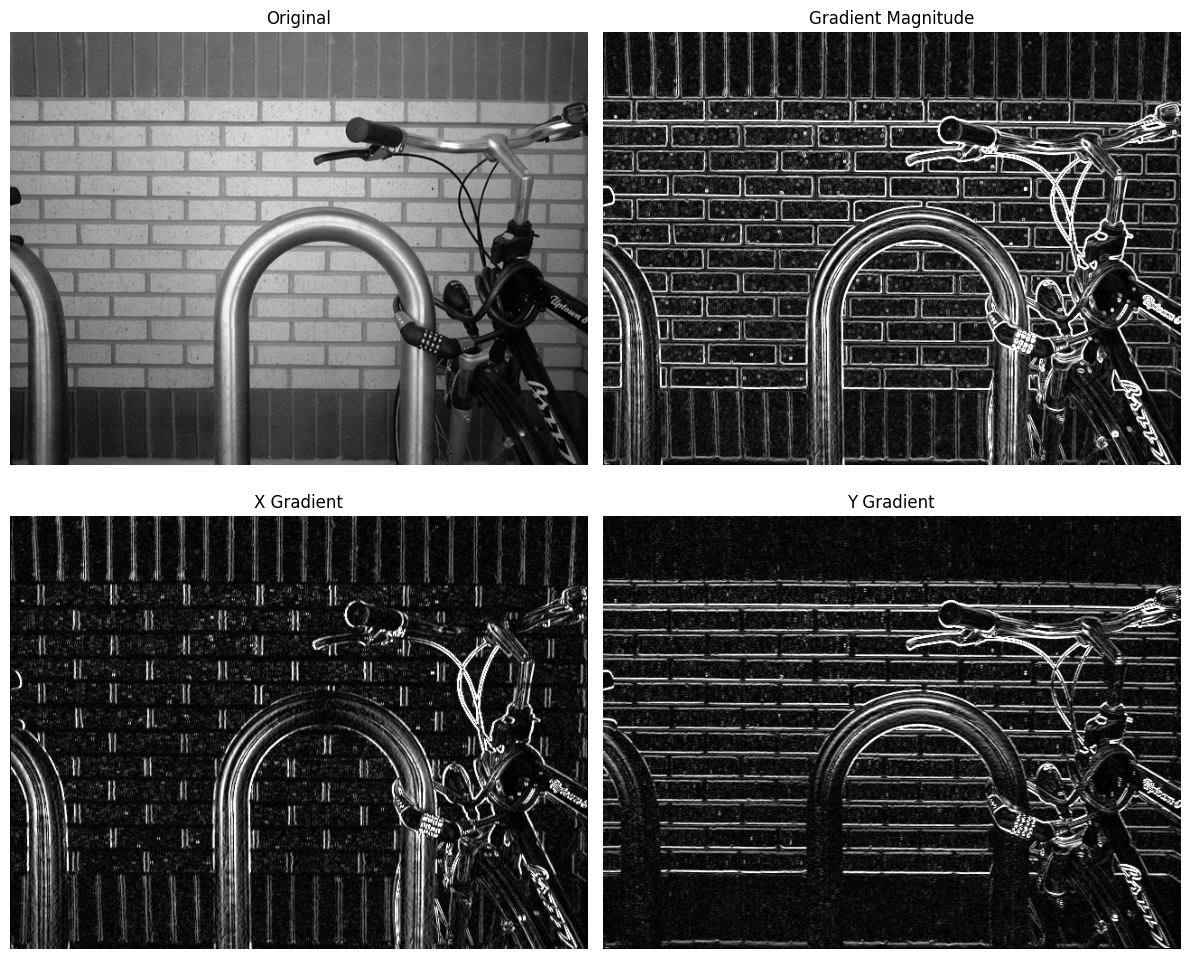

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define Sobel kernels for x and y directions
S_x = np.array([[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]], dtype=np.float32)
S_y = np.array([[1, 2, 1],
                [0, 0, 0],
                [-1, -2, -1]], dtype=np.float32)

# Apply the Sobel filters using filter2D (bike_img loaded in previous cell)
grad_x = cv2.filter2D(bike_img, cv2.CV_32F, S_x)
grad_y = cv2.filter2D(bike_img, cv2.CV_32F, S_y)

# Compute gradient magnitude
grad_mag = cv2.magnitude(grad_x, grad_y)

# Normalize for display
def normalize(img):
    return cv2.convertScaleAbs(img)

grad_x_disp = normalize(grad_x)
grad_y_disp = normalize(grad_y)
grad_mag_disp = normalize(grad_mag)

# Display the original and processed images
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(bike_img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(grad_mag_disp, cmap='gray')
plt.title("Gradient Magnitude")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(grad_x_disp, cmap='gray')
plt.title("X Gradient")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(grad_y_disp, cmap='gray')
plt.title("Y Gradient")
plt.axis('off')

plt.tight_layout()
plt.show()

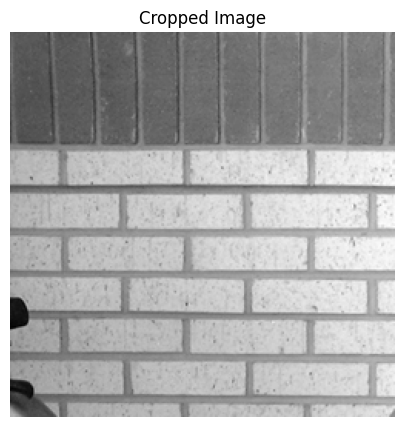

In [8]:
bike_img_crop = bike_img[:250, :250]
plt.figure(figsize=(5, 5))
plt.imshow(bike_img_crop, cmap='gray')
plt.axis('off')
plt.title("Cropped Image")
plt.show()

We will slightly blur the image to reduce the noise

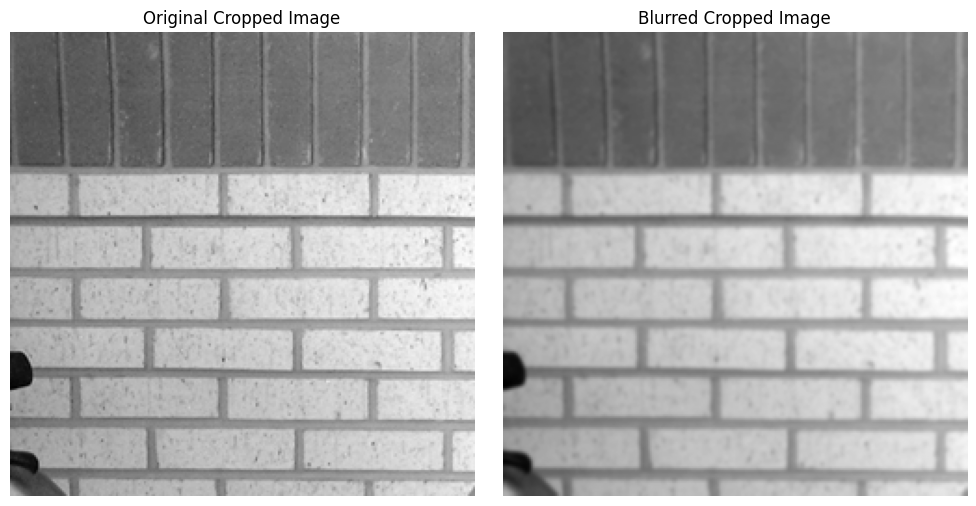

In [9]:
# Apply Gaussian blur with a small sigma to reduce noise
sigma = 1
blurred_bike_img_crop = cv2.GaussianBlur(bike_img_crop, (0, 0), sigma)

# Display the original and blurred images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(bike_img_crop, cmap='gray')
plt.title("Original Cropped Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred_bike_img_crop, cmap='gray')
plt.title("Blurred Cropped Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
def draw_region(image: np.ndarray, top_left: tuple[int, int], size: int, color=(0, 255, 0), thickness=2):
    """
    Рисует прямоугольную область на изображении
    
    Args:
        image: Исходное изображение
        top_left: Координаты верхнего левого угла прямоугольника
        size: Размер стороны прямоугольника
        color: Цвет линии
        thickness: Толщина линии
    """
    bottom_right = (top_left[0] + size, top_left[1] + size)
    image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
    cv2.rectangle(image_copy, top_left, bottom_right, color, thickness)
    return image_copy

In [11]:
def compute_M(region: np.ndarray) -> np.ndarray:
    """
    Вычисляет матрицу M для углового детектора Харриса
    
    Args:
        region: Подрегион изображения
    
    Returns:
        Матрица M размером 2x2
    """
    # Compute gradients using Sobel filters
    I_x = cv2.Sobel(region, cv2.CV_32F, 1, 0, ksize=3)
    I_y = cv2.Sobel(region, cv2.CV_32F, 0, 1, ksize=3)
    
    # Compute elements of M
    I_x2 = I_x**2
    I_y2 = I_y**2
    I_xy = I_x * I_y
    
    # Apply Gaussian blur to the elements
    sigma = 1
    I_x2 = cv2.GaussianBlur(I_x2, (0, 0), sigma)
    I_y2 = cv2.GaussianBlur(I_y2, (0, 0), sigma)
    I_xy = cv2.GaussianBlur(I_xy, (0, 0), sigma)
    
    # Compute M matrix
    M = np.zeros((2, 2))
    M[0, 0] = I_x2.mean()
    M[0, 1] = I_xy.mean()
    M[1, 0] = M[0, 1]
    M[1, 1] = I_y2.mean()
    
    return M

In [12]:
def compute_R(region: np.ndarray, k: float = 0.04) -> float:
    """
    Вычисляет угловую меру Харриса R для подрегиона изображения
    
    Args:
        region: Подрегион изображения
    
    Returns:
        Значение угловой меры R
    """
    M = compute_M(region)
    
    # Compute the corner response R
    det_M = np.linalg.det(M)
    trace_M = np.trace(M)
    R = det_M - k * trace_M**2

    return R


In [13]:
def display_region_with_crop(image: np.ndarray, top_left: tuple[int, int], region_size: int):
    """
    Displays the original image with a highlighted region and the cropped region.
    
    Args:
        image: The input image.
        top_left: The top-left corner of the region to crop.
        region_size: The size of the region to crop.
    """
    # Crop the region
    cropped_region = image[top_left[1]:top_left[1]+region_size, top_left[0]:top_left[0]+region_size]

    # Display the original image with region and the cropped region
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(draw_region(image, top_left, region_size), cmap='gray', vmin=0, vmax=255)
    plt.title("Original with Region")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cropped_region, cmap='gray', vmin=0, vmax=255)
    plt.title("Cropped Region")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return cropped_region



In [14]:
plt.rcParams['text.usetex'] = True  # Enable full LaTeX rendering
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

def create_latex_image_M(M: np.ndarray):
    """
    Displays an image with a LaTeX formula representing the 2x2 matrix M.
    
    Args:
        M: 2x2 numpy array representing the matrix.
    """
    if M.shape != (2, 2):
        raise ValueError("Matrix M must be 2x2")
    
    # Use the matrix environment with parentheses, which is supported by mathtext
    latex_str = (r"\[ M = \begin{bmatrix} " +
                 f"{M[0, 0]:.2f}" + r" & " + f"{M[0, 1]:.2f}" + r" \\" +
                 f"{M[1, 0]:.2f}" + r" & " + f"{M[1, 1]:.2f}" +
                 r" \end{bmatrix} \]")

    # Create a figure and display the LaTeX string
    plt.figure(figsize=(2, 1), dpi=200)
    plt.text(0, 0, latex_str, fontsize=42, ha='center', va='center')
    plt.axis('off')
    plt.show()

def create_latex_image_R(R: float):
    """
    Displays an image with a LaTeX formula representing the Harris corner measure R.
    
    Args:
        R: The Harris corner measure value.
    """
    # Use the matrix environment with parentheses, which is supported by mathtext
    latex_str = (r"\[ R = \det(M) - k \, \text{trace}(M)^2 = " +
                 f"{R:.2f}" + r" \]")

    # Create a figure and display the LaTeX string
    plt.figure(figsize=(2, 1), dpi=200)
    plt.text(0, 0, latex_str, fontsize=42, ha='center', va='center')
    plt.axis('off')
    plt.show()


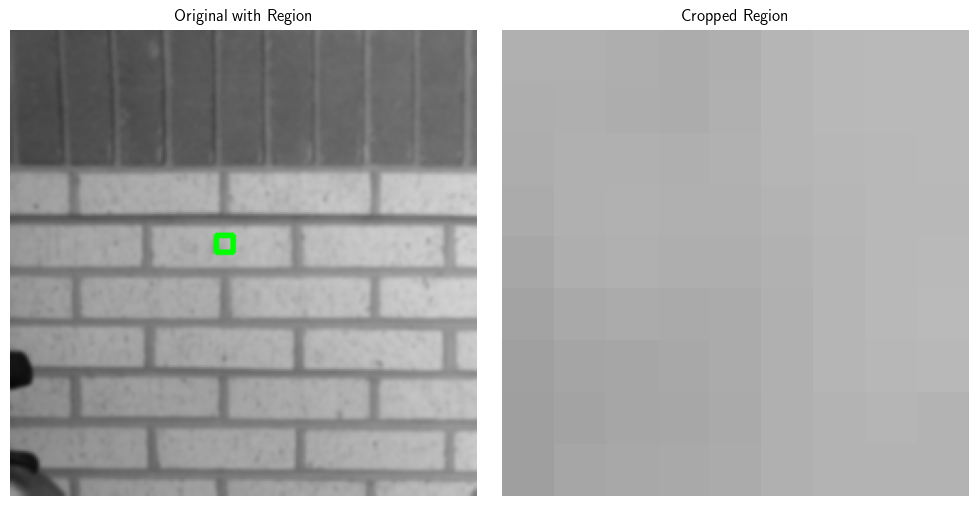

In [15]:
# Example usage
region_size = 9
top_left = (110, 110)
homogeneous_region = display_region_with_crop(blurred_bike_img_crop, top_left, region_size)

Homogeneous Region M: 
[[378.69665527 -81.92536926]
 [-81.92536926 143.6335144 ]]
Homogeneous Region R: 36768.61


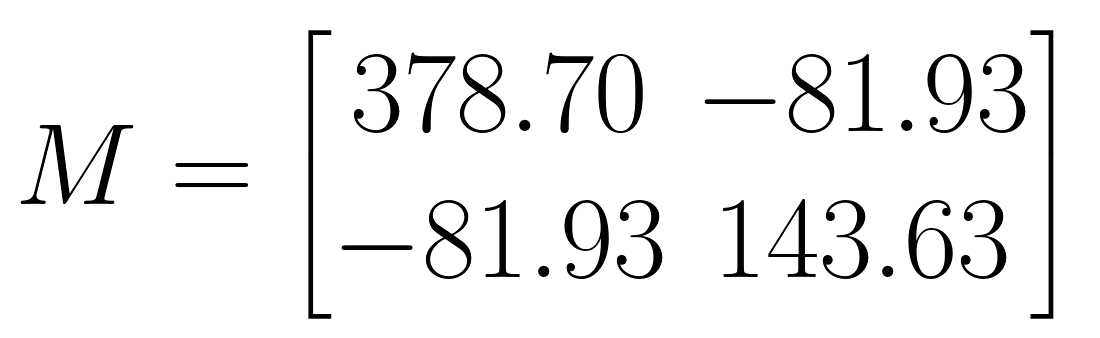

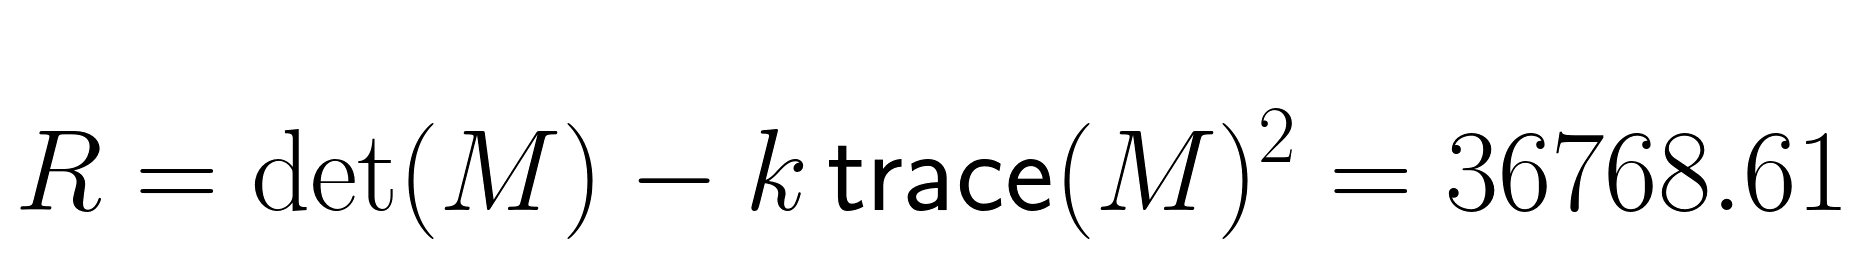

In [16]:
M_homogeneous = compute_M(homogeneous_region)
R_homogeneous = compute_R(homogeneous_region)
print(f"Homogeneous Region M: \n{M_homogeneous}")
print(f"Homogeneous Region R: {R_homogeneous:.2f}")
create_latex_image_M(M_homogeneous)
create_latex_image_R(R_homogeneous)

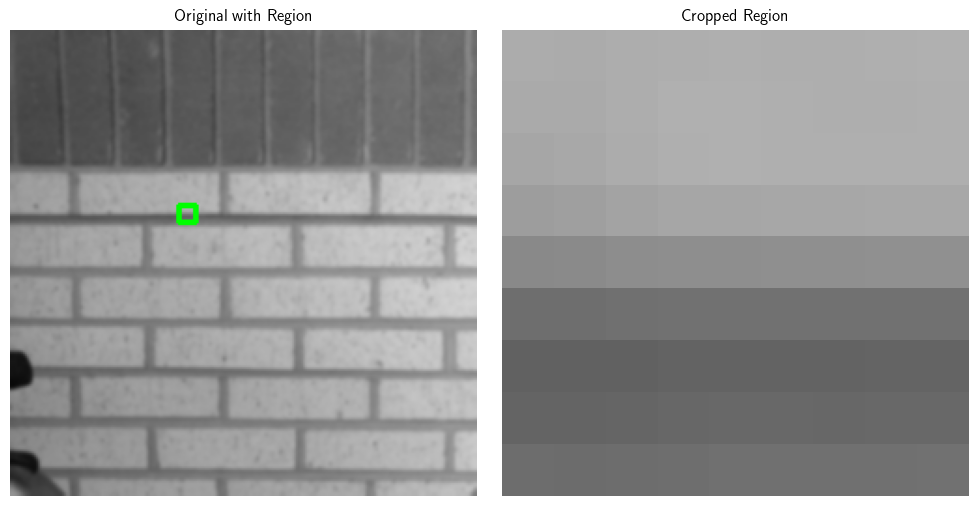

In [17]:
region_size = 9
top_left = (90, 94)

# Crop the region
horizontal_border = display_region_with_crop(blurred_bike_img_crop, top_left, region_size)

Horizontal Border M: 
[[   78.98595428  -376.55496216]
 [ -376.55496216 10616.25585938]]
Horizontal Border R: -3878786.44


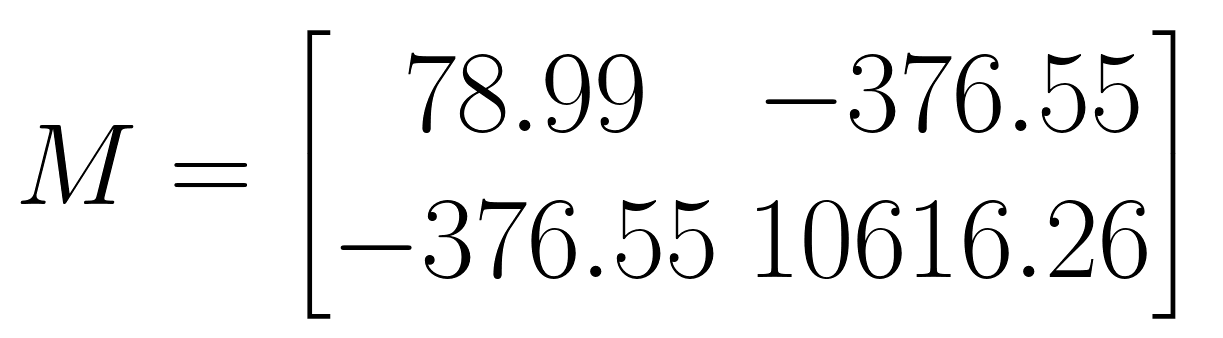

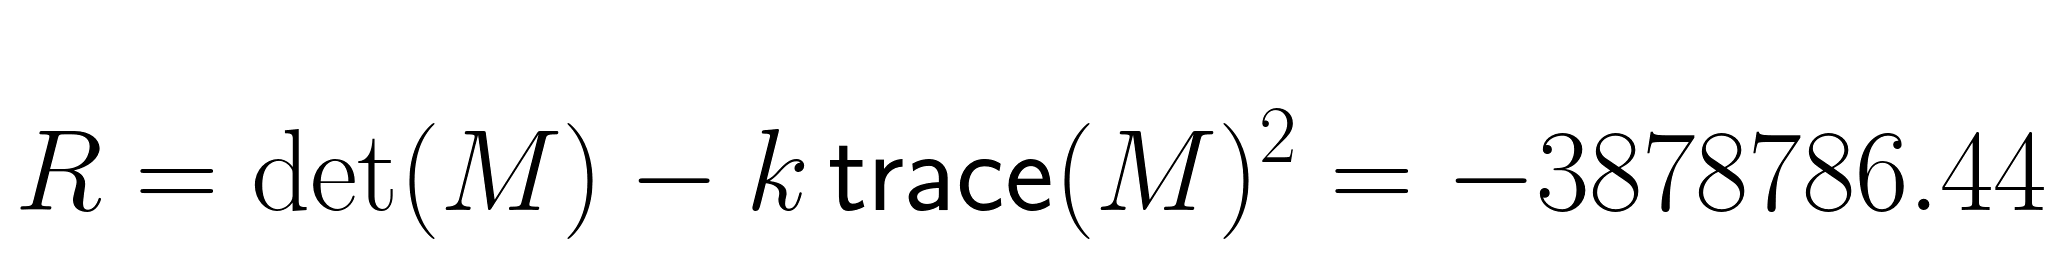

In [18]:
# Construct the M matrix
M_horizontal = compute_M(horizontal_border)
R_horizontal = compute_R(horizontal_border)
print(f"Horizontal Border M: \n{M_horizontal}")
print(f"Horizontal Border R: {R_horizontal:.2f}")
create_latex_image_M(M_horizontal)
create_latex_image_R(R_horizontal)

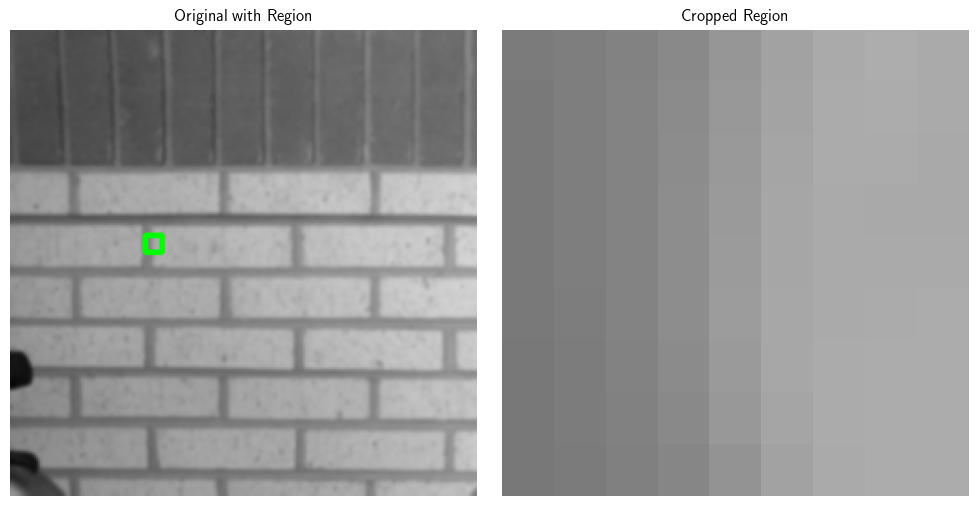

In [19]:
region_size = 9
top_left = (72, 110)

# Crop the region
vertical_border = display_region_with_crop(blurred_bike_img_crop, top_left, region_size)

Vertical Border M: 
[[3295.13891602  -78.05142212]
 [ -78.05142212   50.20029449]]
Vertical Border R: -288326.86


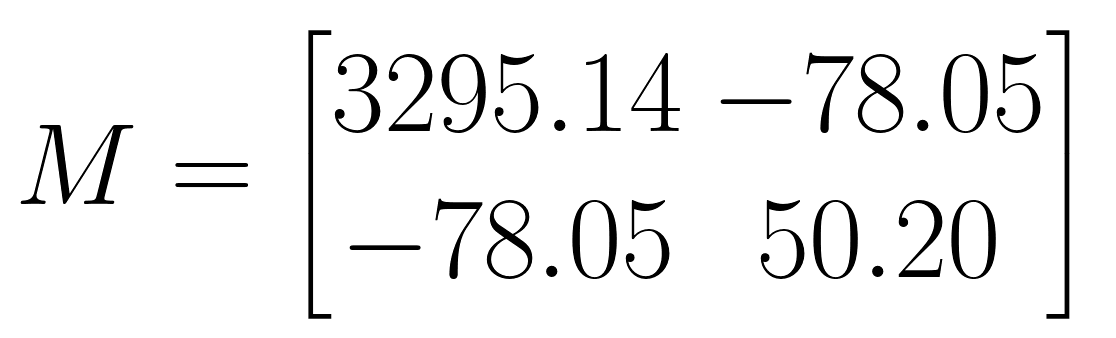

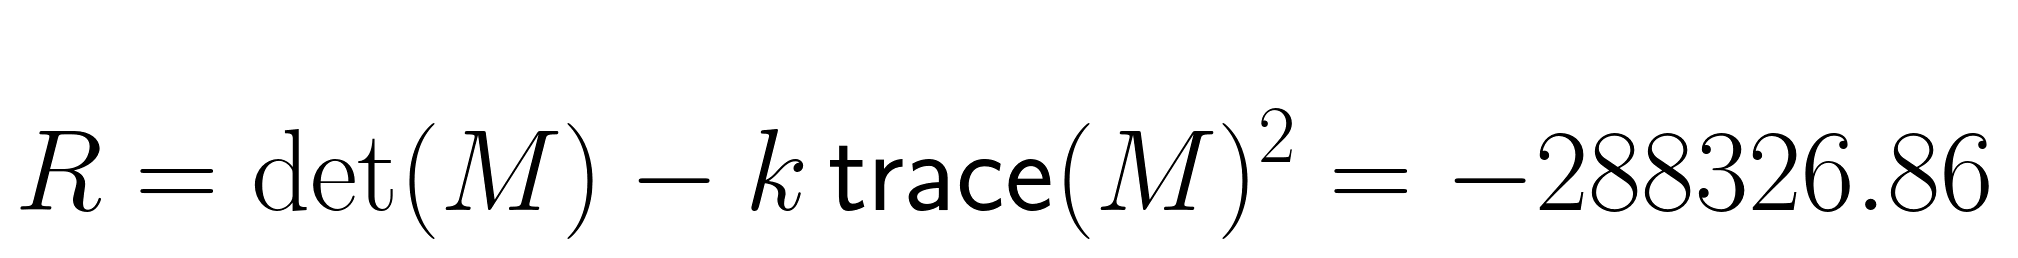

In [20]:
M_vertical = compute_M(vertical_border)
R_vertical = compute_R(vertical_border)
print(f"Vertical Border M: \n{M_vertical}")
print(f"Vertical Border R: {R_vertical:.2f}")
create_latex_image_M(M_vertical)
create_latex_image_R(R_vertical)

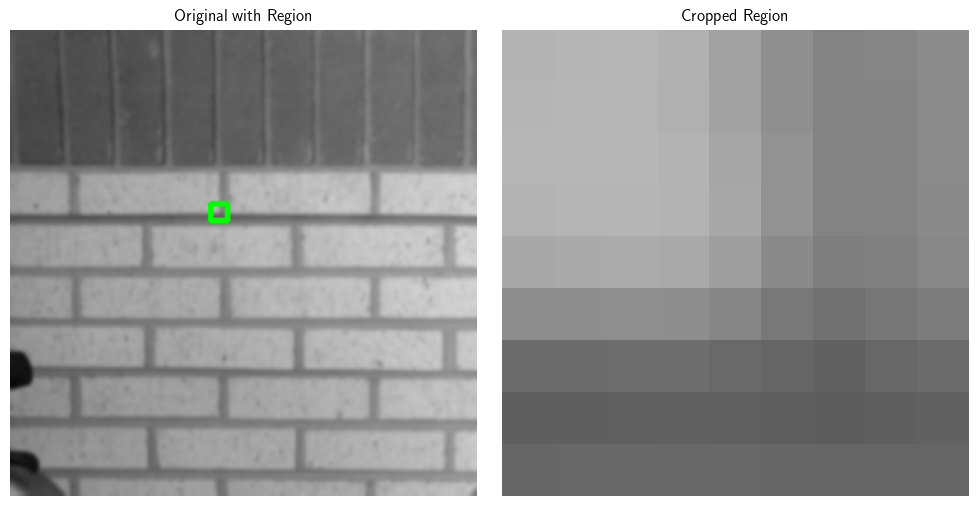

In [21]:
region_size = 9
top_left = (107, 93)

# Crop the region
corner_region = display_region_with_crop(blurred_bike_img_crop, top_left, region_size)

Corner Region M: 
[[2879.48583984  913.83056641]
 [ 913.83056641 8512.35351562]]
Corner Region R: 18485154.95


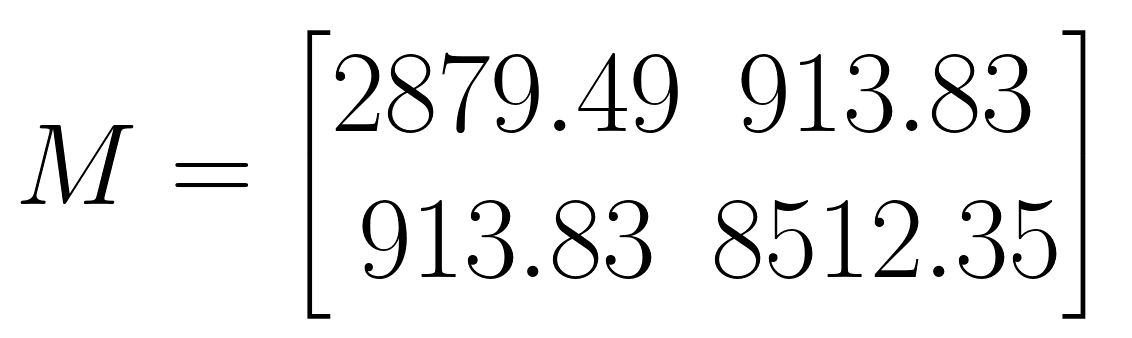

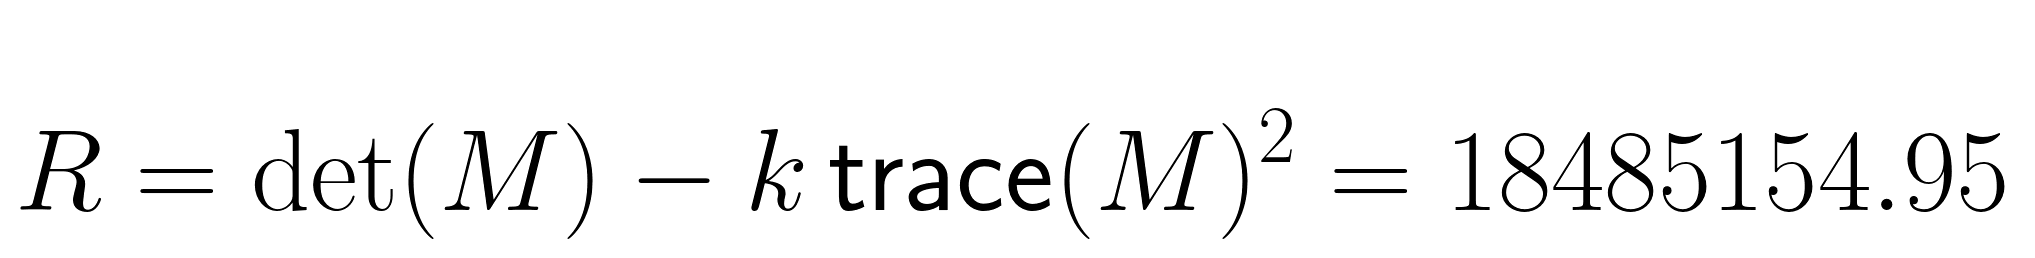

In [22]:
M_corner = compute_M(corner_region)
R_corner = compute_R(corner_region)
print(f"Corner Region M: \n{M_corner}")
print(f"Corner Region R: {R_corner:.2f}")
create_latex_image_M(M_corner)
create_latex_image_R(R_corner)

In [23]:
print(f"Homogeneous Region M: \n{M_homogeneous}")
print(f"Homogeneous Region R: {R_homogeneous:.2f}")
print(f"Horizontal Border M: \n{M_horizontal}")
print(f"Horizontal Border R: {R_horizontal:.2f}")
print(f"Vertical Border M: \n{M_vertical}")
print(f"Vertical Border R: {R_vertical:.2f}")
print(f"Corner Region M: \n{M_corner}")
print(f"Corner Region R: {R_corner:.2f}")

Homogeneous Region M: 
[[378.69665527 -81.92536926]
 [-81.92536926 143.6335144 ]]
Homogeneous Region R: 36768.61
Horizontal Border M: 
[[   78.98595428  -376.55496216]
 [ -376.55496216 10616.25585938]]
Horizontal Border R: -3878786.44
Vertical Border M: 
[[3295.13891602  -78.05142212]
 [ -78.05142212   50.20029449]]
Vertical Border R: -288326.86
Corner Region M: 
[[2879.48583984  913.83056641]
 [ 913.83056641 8512.35351562]]
Corner Region R: 18485154.95


# SIFT

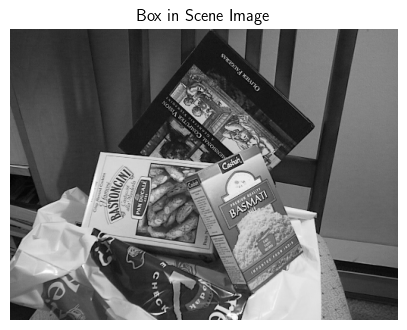

In [24]:
box_in_scene_img = cv2.imread("data/box_in_scene.png", cv2.IMREAD_GRAYSCALE)

# Display the box in the scene image
plt.figure(figsize=(5, 5))
plt.imshow(box_in_scene_img, cmap='gray')
plt.axis('off')
plt.title("Box in Scene Image")
plt.show()

In [25]:
def compute_SIFT(img: np.ndarray) -> tuple[list[cv2.KeyPoint], np.ndarray, np.ndarray]:
    """
    Вычисляет ключевые точки и дескрипторы SIFT для изображения
    
    Args:
        img: Входное изображение
    
    Returns:
        Список ключевых точек и дескрипторов SIFT, а также изображение с нарисованными ключевыми точками
    """
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Find keypoints and descriptors
    kp, des = sift.detectAndCompute(img, None)
    
    # Draw keypoints and descriptors
    img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return kp, des, img_kp


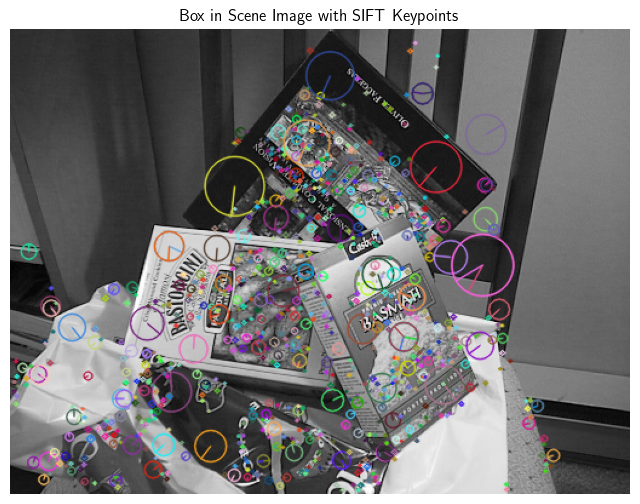

In [26]:
kp, des, img_kp = compute_SIFT(box_in_scene_img)

# Display the image with keypoints
plt.figure(figsize=(8, 8))
plt.imshow(img_kp)
plt.axis('off')
plt.title("Box in Scene Image with SIFT Keypoints")
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec

def build_gaussian_pyramid(image, num_octaves=4, num_scales=5, sigma_start=1.6):
    """
    Build a Gaussian pyramid.
    
    Returns a list of octaves, each containing a list of Gaussian-blurred images.
    """
    image = image.astype(np.float32) / 255.0  # normalize to [0,1]
    gaussian_pyramid = []
    current_image = image.copy()

    for octave_index in range(num_octaves):
        # Typical SIFT uses: k = 2^(1/(num_scales - 3))
        k = 2 ** (1.0 / (num_scales - 3))
        sigmas = [sigma_start * (k ** i) for i in range(num_scales)]

        octave_images = []
        for sigma in sigmas:
            blurred = cv2.GaussianBlur(current_image, (0, 0), sigmaX=sigma, sigmaY=sigma)
            octave_images.append(blurred)
        
        gaussian_pyramid.append(octave_images)

        # Downsample for next octave (using one of the middle scales, here the third-to-last)
        next_octave_base = octave_images[-3]
        h, w = next_octave_base.shape
        current_image = cv2.resize(next_octave_base, (w // 2, h // 2), interpolation=cv2.INTER_NEAREST)

    return gaussian_pyramid

def build_dog_pyramid(gaussian_pyramid):
    """
    Build the Difference-of-Gaussians (DoG) pyramid.
    
    For each octave, compute the difference between consecutive Gaussian images.
    """
    dog_pyramid = []
    for octave_images in gaussian_pyramid:
        octave_dogs = []
        for i in range(1, len(octave_images)):
            dog = octave_images[i] - octave_images[i - 1]
            octave_dogs.append(dog)
        dog_pyramid.append(octave_dogs)
    return dog_pyramid

def visualize_first_octave_grid(original, gaussian_octave, dog_octave, sigma_start=1.6):
    """
    Visualize a grid with 3 columns:
      - Column 1: The original (unmodified) first octave image.
      - Column 2: The Gaussian-blurred images (different scales) in the first octave,
                  with sigma values in the title.
      - Column 3: The corresponding DoG images in the first octave.
      
    The grid uses as many rows as there are scales (for Gaussian, e.g., 5). For DoG (typically one fewer than scales)
    the extra cell is left blank.
    """
    num_scales = len(gaussian_octave)    # e.g., 5
    num_dogs = len(dog_octave)           # e.g., 4
    rows = num_scales

    # Compute sigma values using the SIFT formula: sigma[i] = sigma_start * k^i, where k = 2^(1/(num_scales-3))
    k = 2 ** (1.0 / (num_scales - 3))
    sigma_values = [sigma_start * (k ** i) for i in range(num_scales)]

    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(rows, 3, width_ratios=[1, 1, 1])

    # --- Column 1: Original first octave image ---
    # We display the original image (converted to [0,1]) in a subplot that spans all rows.
    ax_orig = fig.add_subplot(gs[:, 0])
    ax_orig.imshow(original, cmap='gray')
    ax_orig.set_title("Original (Octave 1)")
    ax_orig.axis('off')

    # --- Column 2: Gaussian blurred images (scales) with sigma values ---
    for i in range(rows):
        ax = fig.add_subplot(gs[i, 1])
        ax.imshow(gaussian_octave[i], cmap='gray')
        ax.set_title(f"Gaussian Scale {i}\nσ = {sigma_values[i]:.2f}")
        ax.axis('off')

    # --- Column 3: DoG images ---
    for i in range(rows):
        ax = fig.add_subplot(gs[i, 2])
        if i < num_dogs:
            dog_img = dog_octave[i]
            # Normalize DoG for display (they may have negative values)
            d_min, d_max = dog_img.min(), dog_img.max()
            dog_img_norm = (dog_img - d_min) / (d_max - d_min + 1e-8)
            ax.imshow(dog_img_norm, cmap='gray')
            ax.set_title(f"DoG {i}")
        else:
            ax.set_title("")  # leave blank if no DoG available
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Build the Gaussian pyramid and DoG pyramid
num_octaves = 4
num_scales = 5
sigma_start = 1.6
gaussian_pyramid = build_gaussian_pyramid(box_in_scene_img, num_octaves=num_octaves, num_scales=num_scales, sigma_start=sigma_start)
dog_pyramid = build_dog_pyramid(gaussian_pyramid)

# For visualization we only use the first octave.
# Column 1: Use the original input image (normalized) as the "original" of the first octave.
original_first_octave = box_in_scene_img.astype(np.float32) / 255.0
first_octave_gaussians = gaussian_pyramid[0]  # List of Gaussian images in octave 1
first_octave_dogs = dog_pyramid[0]              # List of DoG images in octave 1

visualize_first_octave_grid(original_first_octave, first_octave_gaussians, first_octave_dogs, sigma_start=sigma_start)


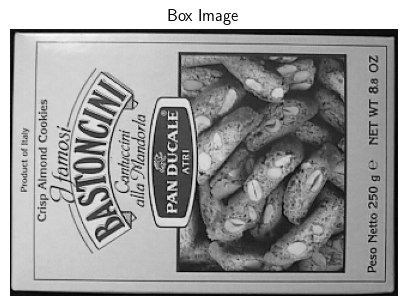

In [28]:
box_img = cv2.imread("data/box.png", cv2.IMREAD_GRAYSCALE)

# Display the box image
plt.figure(figsize=(5, 5))
plt.imshow(box_img, cmap='gray')
plt.axis('off')
plt.title("Box Image")
plt.show()

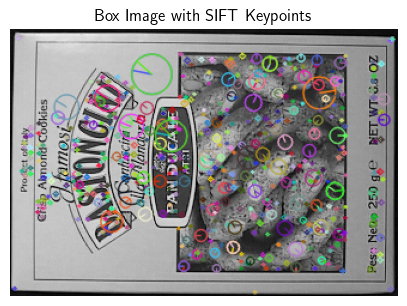

In [30]:
ref_kp, ref_des, ref_img_kp = compute_SIFT(box_img)

# Display the image with keypoints
plt.figure(figsize=(5, 5))
plt.imshow(ref_img_kp)
plt.axis('off')
plt.title("Box Image with SIFT Keypoints")
plt.show()

In [31]:
def match_keypoints(des1: np.ndarray, des2: np.ndarray, ratio_thresh=0.75):
    """
    Находит хорошие сопоставления между двумя наборами дескрипторов
    
    Args:
        des1: Дескрипторы первого изображения
        des2: Дескрипторы второго изображения
        ratio_thresh: Пороговое значение для фильтрации сопоставлений
    
    Returns:
        Список хороших сопоставлений
    """
    # Инициализируем BFMatcher с нормой L2
    bf = cv2.BFMatcher(cv2.NORM_L2)
    
    # Находим k=2 ближайших соседа для каждого дескриптора
    matches_knn = bf.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches_knn:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    return good_matches

def draw_matches(img1: np.ndarray, kp1: list[cv2.KeyPoint], img2: np.ndarray, kp2: list[cv2.KeyPoint], matches: list[cv2.DMatch]):
    """
    Рисует сопоставления между двумя изображениями
    
    Args:
        img1: Первое изображение
        kp1: Ключевые точки первого изображения
        img2: Второе изображение
        kp2: Ключевые точки второго изображения
        matches: Список сопоставлений
    """
    # Рисуем сопоставления на новом изображении
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Отображаем результат
    plt.figure(figsize=(10, 10))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title("Matches")
    plt.tight_layout()
    plt.show()

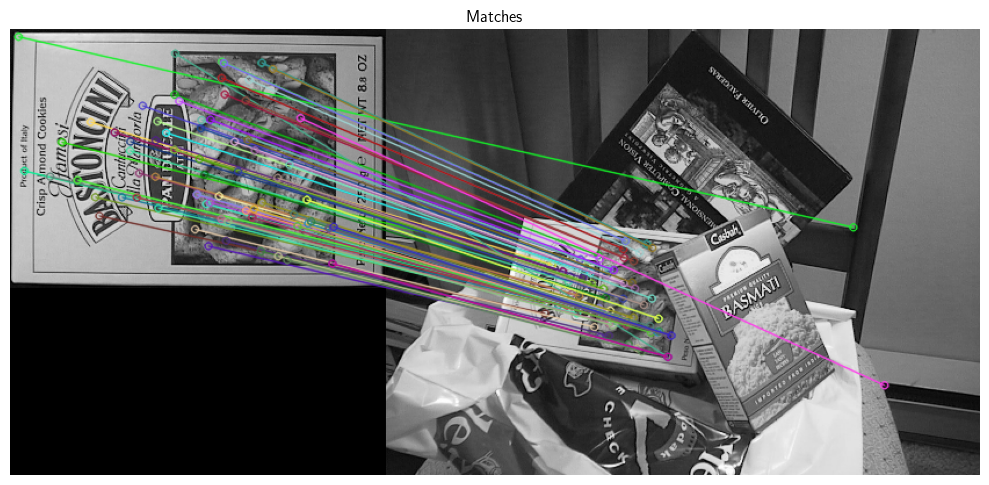

In [32]:
good_matches = match_keypoints(ref_des, des)

draw_matches(box_img, ref_kp, box_in_scene_img, kp, good_matches)

# ORB

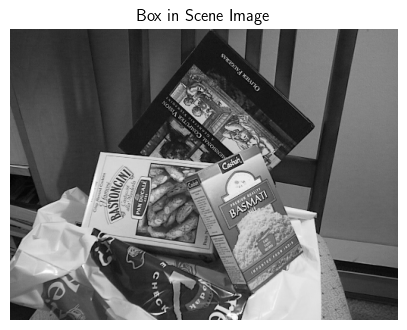

In [33]:
box_in_scene_img = cv2.imread("data/box_in_scene.png", cv2.IMREAD_GRAYSCALE)

# Display the box in the scene image
plt.figure(figsize=(5, 5))
plt.imshow(box_in_scene_img, cmap='gray')
plt.axis('off')
plt.title("Box in Scene Image")
plt.show()

In [34]:
def compute_ORB(img: np.ndarray) -> tuple[list[cv2.KeyPoint], np.ndarray, np.ndarray]:
    """
    Вычисляет ключевые точки и дескрипторы ORB для изображения
    
    Args:
        img: Входное изображение
    
    Returns:
        Список ключевых точек и дескрипторов ORB, а также изображение с нарисованными ключевыми точками
    """
    # Initialize ORB detector
    orb = cv2.ORB_create()
    
    # Find keypoints and descriptors
    kp, des = orb.detectAndCompute(img, None)
    
    # Draw keypoints
    img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return kp, des, img_kp

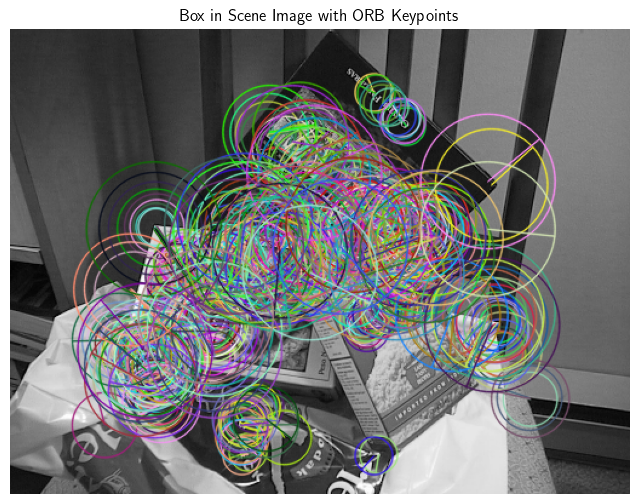

In [35]:
orb_kp, orb_des, orb_img_kp = compute_ORB(box_in_scene_img)

# Display the image with ORB keypoints
plt.figure(figsize=(8, 8))
plt.imshow(orb_img_kp)
plt.axis('off')
plt.title("Box in Scene Image with ORB Keypoints")
plt.show()

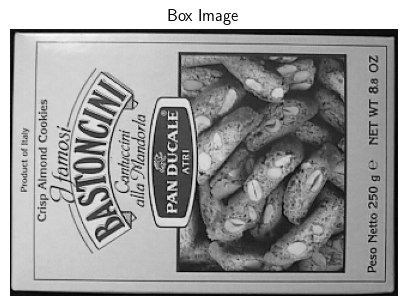

In [36]:
box_img = cv2.imread("data/box.png", cv2.IMREAD_GRAYSCALE)

# Display the box image
plt.figure(figsize=(5, 5))
plt.imshow(box_img, cmap='gray')
plt.axis('off')
plt.title("Box Image")
plt.show()

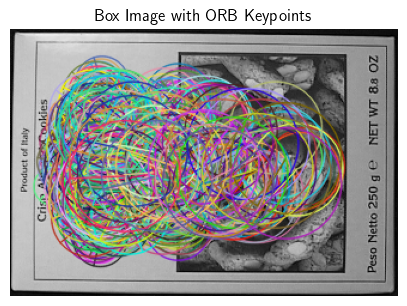

In [40]:
orb_ref_kp, orb_ref_des, orb_ref_img_kp = compute_ORB(box_img)

# Display the image with ORB keypoints
plt.figure(figsize=(5, 5))
plt.imshow(orb_ref_img_kp)
plt.axis('off')
plt.title("Box Image with ORB Keypoints")
plt.show()

In [41]:
def match_keypoints_ORB(des1: np.ndarray, des2: np.ndarray, ratio_thresh=0.75):
    """
    Находит хорошие сопоставления между двумя наборами дескрипторов
    
    Args:
        des1: Дескрипторы первого изображения
        des2: Дескрипторы второго изображения
        ratio_thresh: Пороговое значение для фильтрации сопоставлений
    
    Returns:
        Список хороших сопоставлений
    """
    # Инициализируем BFMatcher с нормой Hamming
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    
    # Находим k=2 ближайших соседа для каждого дескриптора
    matches_knn = bf.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches_knn:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    return good_matches

def draw_matches(img1: np.ndarray, kp1: list[cv2.KeyPoint], img2: np.ndarray, kp2: list[cv2.KeyPoint], matches: list[cv2.DMatch]):
    """
    Рисует сопоставления между двумя изображениями
    
    Args:
        img1: Первое изображение
        kp1: Ключевые точки первого изображения
        img2: Второе изображение
        kp2: Ключевые точки второго изображения
        matches: Список сопоставлений
    """
    # Рисуем сопоставления на новом изображении
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Отображаем результат
    plt.figure(figsize=(10, 10))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title("Matches")
    plt.tight_layout()
    plt.show()
    

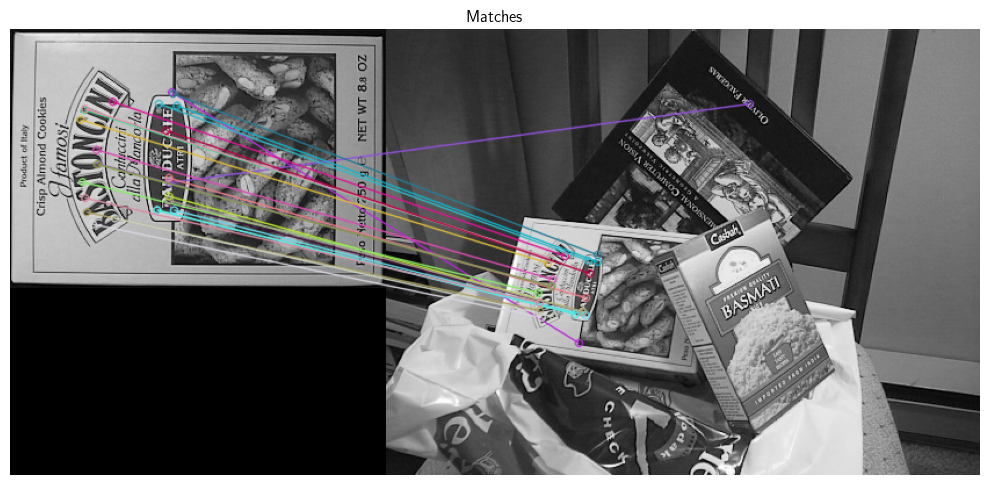

In [42]:
good_matches_orb = match_keypoints_ORB(ref_des, orb_des)

draw_matches(box_img, orb_ref_kp, box_in_scene_img, orb_kp, good_matches_orb)